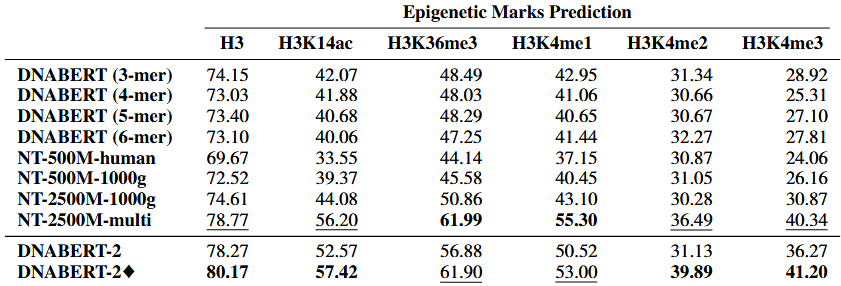

In [50]:
# standard libraries
import math
import os
import tempfile
from pathlib import Path
import json
import sys
import pickle
from pprint import pprint

# standard scientific libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray, save, load
import pandas as pd
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import load_model
from keras.utils import to_categorical, plot_model

# torch
import torch

# huggingface
from transformers import BertForSequenceClassification, PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import evaluate

# scikit-learn
from sklearn.metrics import accuracy_score, precision_score, average_precision_score, recall_score, matthews_corrcoef, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [76]:
def plot_confusion_matrix(confusion_matrix, title=""):
    fig, ax = plt.subplots(figsize=(1.25*len(confusion_matrix[0]),1*len(confusion_matrix)))
    sns.heatmap(confusion_matrix, annot=True, fmt="d")
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_aspect('equal')

In [15]:
def plot_loss(loss, title = ""):
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.plot(loss["epoch"], loss["loss"])

In [82]:
def plot_roc(fpr, tpr, auc, title = "", **kwargs):
    fig, ax = plt.subplots()
    ax.set_title('Receiver operating characteristic (ROC) curve')
    ax.set_xlabel('False positives rate = fp/(fp+tn)')
    ax.set_ylabel('True positives rate = tp/(tp+fn)')
    ax.set_xlim([0,1]); ax.set_ylim([0,1])
    ax.set_aspect('equal')
    
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random') # Random line

    if type(auc) is not np.ndarray:
        ax.plot(fpr, tpr, label=f'{title} AUC = {auc:.2f}', linewidth=2, **kwargs)
    else:
        for idx, auc_score in enumerate(auc):
            ax.plot(fpr[idx], tpr[idx], label=f'{title}_{idx} AUC = {auc_score:.2f}', linewidth=2, **kwargs)
    
    ax.legend(loc='lower right')

In [ ]:
# TODO Calculate hypergeometric distribution
import numpy as np

from scipy.stats import hypergeom

import matplotlib.pyplot as plt

[M, n, N] = [20, 7, 12]

rv = hypergeom(M, n, N)
x = np.arange(0, n+1)
pmf_dogs = rv.pmf(x)

In [108]:
# Metrics

def get_metrics(labels, predictions):
    metrics = {}

    classes = unique_labels(labels)
    
    if len(classes) <= 2:
        average = "binary"
        
        # ROC
        metrics["auc"] = roc_auc_score(labels, predictions)
        fpr, tpr, _ = roc_curve(labels.argmax(axis=1), predictions[:,1])  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)
        metrics["fpr"], metrics["tpr"] = fpr, tpr
    else:
        average = None # TODO change to e.g. "min"?
        
        # ROC
        
        # TODO ask e.g. gabriele what would be the best multi-class metric? including the "average" parameter for other metrics. is ROC necessary?

        #! sklearn roc_auc_score only handles "macro" and "weighted": If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Note: multiclass ROC AUC currently only handles the ‘macro’ and ‘weighted’ averages. For multiclass targets, average=None is only implemented for multi_class='ovr' and average='micro' is only implemented for multi_class='ovr'.

        #! Theoretically speaking, you could implement OVR and calculate per-class roc_auc_score, as:
        # roc = {label: [] for label in multi_class_series.unique()}
        # for label in multi_class_series.unique():
        #     selected_classifier.fit(train_set_dataframe, train_class == label)
        #     predictions_proba = selected_classifier.predict_proba(test_set_dataframe)
        #     roc[label] += roc_auc_score(test_class, predictions_proba[:,1])
        # https://stackoverflow.com/questions/59666138/sklearn-roc-auc-score-with-multi-class-ovr-should-have-none-average-available

        # TODO commented out for now
        # metrics["auc"] = roc_auc_score(labels, predictions, multi_class='ovr', average=None) # TODO something wrong here? ovo or ovr?
        # fprs, tprs = [], []
        # for index, class_name in enumerate(classes):
        #     fpr, tpr, _ = roc_curve(labels[:,index], predictions[:,index])
        #     fprs += [fpr]; tprs += [tpr]
        # metrics["fpr"], metrics["tpr"] = fprs, tprs
    
    labels, predictions = labels.argmax(axis=1), predictions.argmax(axis=1)
    
    metrics["confusion_matrix"] = confusion_matrix(labels, predictions)
    metrics["accuracy"] = accuracy_score(labels, predictions)
    metrics["precision"] = precision_score(labels, predictions, average=average)
    metrics["recall"] = recall_score(labels, predictions, average=average)
    metrics["f1"] = f1_score(labels, predictions, average=average)
    metrics["mcc"] = matthews_corrcoef(labels, predictions)

    return metrics

In [107]:
# Tensorflow functions

def get_tf_labels_features(data_path, num_classes):
    matrices = np.load(data_path, allow_pickle=True)
    features = np.stack(matrices['arr_0'], axis=0)
    data_name = data_path.stem.split("_")[0]
    labels = np.load(data_path.parents[0]/f"{data_name}_labels.npy", allow_pickle=True)
    labels = to_categorical(labels, num_classes=num_classes)
    return labels, features


def get_tf_model(model_dir):
    model = load_model(model_dir, custom_objects={'f1': tfa.metrics.F1Score, 'mcc': tfa.metrics.MatthewsCorrelationCoefficient})
    return model


def get_tf_predictions(model, features, batch_size):
    predictions = model.predict(features, batch_size = batch_size)
    return predictions


# def get_tf_metrics(labels, predictions):
    # metrics = model.evaluate(features, labels, verbose=0) # batch_size=batch_size
    # metrics = dict(zip(model.metrics_names, metrics))
    # return metrics


def get_tf_loss(path):
    with open(path, "rb") as file:
        history = pickle.load(file)
        loss = history["loss"]
    loss_dict = {"epoch": list(range(len(loss))), "loss": loss}
    return loss_dict


def stats_tensorflow(DATA_PATH, MODEL_DIR, NUM_CLASSES, BATCH_SIZE = 16, TITLE = ""):
    labels, features = get_tf_labels_features(DATA_PATH, NUM_CLASSES)
    model = get_tf_model(MODEL_DIR)
    predictions = get_tf_predictions(model, features, BATCH_SIZE)
    metrics = get_metrics(labels, predictions) # TODO set lowest loss
    loss = get_tf_loss(MODEL_DIR/"history")

    pprint(metrics)
    
    plot_confusion_matrix(metrics["confusion_matrix"], title=TITLE)
    plot_loss(loss, title=TITLE)
    if NUM_CLASSES <= 2: # TODO
        plot_roc(metrics["fpr"], metrics["tpr"], metrics["auc"], title=TITLE)

In [106]:
# PyTorch functions

def get_torch_labels_features(data_path, num_classes):
    data = pd.read_csv(data_path)
    labels = list(data['label'])
    labels = to_categorical(labels, num_classes=num_classes)
    features = list(data['sequence'])
    return labels, features


def get_torch_model_tokenizer(model_dir):
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
    return model, tokenizer


def get_torch_predictions(model, tokenizer, features): 
    
    # Tokenize texts and convert to tensors
    input = tokenizer(features, padding="longest", truncation=True, return_tensors='pt', max_length=tokenizer.model_max_length)
    
    # Forward pass to get predictions
    with torch.no_grad(): # Disabling gradient calculation, useful for inference
        output = model(**input)
        logits = output.logits
    
    # Get predicted probabilities
    predictions = torch.softmax(logits, dim=1).numpy()
    
    return predictions


# def get_torch_metrics(path): 
#     with open(path, "r") as file:
#         eval = json.load(file)
#     metrics = {
#             "loss": eval["eval_loss"],
#             "accuracy": eval["eval_accuracy"],
#             "precision": eval["eval_precision"],
#             "recall": eval["eval_recall"],
#             "f1": eval["eval_f1"],
#             "mcc": eval["eval_matthews_correlation"]}
#     return metrics


def get_torch_loss(path):
    with open(path, "r") as file:
        trainer_state = json.load(file)
    log_history = trainer_state["log_history"][2::3] # Every third entry contains these metrics
    epoch = [log["epoch"] for log in log_history]
    loss = [log["eval_loss"] for log in log_history]
    loss_dict = {"epoch": epoch, "loss": loss}
    return loss_dict


def stats_pytorch(DATA_PATH, MODEL_DIR, NUM_CLASSES, TITLE = ""):
    labels, features = get_torch_labels_features(DATA_PATH, NUM_CLASSES)
    model, tokenizer = get_torch_model_tokenizer(MODEL_DIR)
    predictions = get_torch_predictions(model, tokenizer, features)

    metrics = get_metrics(labels, predictions) # TODO add minimum loss
    loss = get_torch_loss(MODEL_DIR/"trainer_state.json")
    
    pprint(metrics)
    
    plot_confusion_matrix(metrics["confusion_matrix"], title=TITLE)
    plot_loss(loss, title=TITLE)
    if NUM_CLASSES <= 2: # TODO
        plot_roc(metrics["fpr"], metrics["tpr"], metrics["auc"], title=TITLE)

In [42]:
# Config

mpl.rcParams['figure.figsize'] = [8, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/cephyr/users/xinhex/Alvis/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


[0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0
 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1
 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0
 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0
 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1
 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1
 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0
 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1
 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 1 

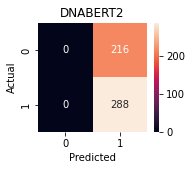

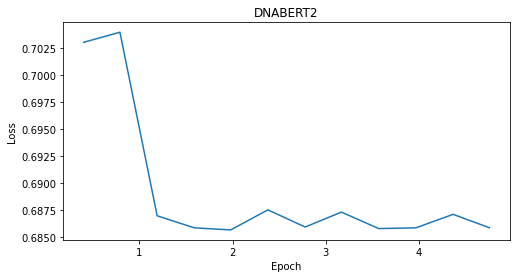

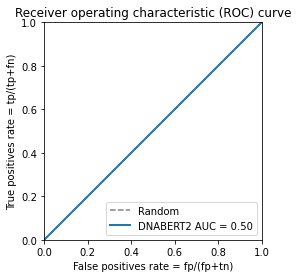

In [81]:
# PyTorch

# DATA_PATH = Path("../data_generation/training_data/clusters_8_80_T/test.csv") 
# MODEL_DIR = Path("results/DNABERT2/alvis/tetraloop/clusters_8_80_T_1")
# DATA_PATH = Path("../data_generation/training_data/tloop_8_80_T/test.csv") 
# MODEL_DIR = Path("results/DNABERT2/alvis/tetraloop/tloop_8_80_T_1")
# DATA_PATH = Path("results/DNABERT2/old/gnra_f14_r80_m3/model_data/test.csv") 
# MODEL_DIR = Path("results/DNABERT2/old/gnra_f14_r80_m3/output")
DATA_PATH = Path("../data_generation/training_data/gnra_8_80_T/test.csv") 
MODEL_DIR = Path("results/DNABERT2/alvis/tetraloop/gnra_8_80_T_1")
TITLE ="DNABERT2"
NUM_CLASSES = 2

stats_pytorch(DATA_PATH, MODEL_DIR, NUM_CLASSES, TITLE)

259/259 [==============================] - 0s 1ms/step
{'accuracy': 0.5534332688588007,
 'auc': array([0.93909954, 0.93077241, 0.98341771, 0.9998544 , 1.        ,
       0.99990305, 0.97877263, 1.        , 0.99825497, 1.        ,
       0.9997334 , 0.99963645, 0.99443234, 0.99746403, 0.99185206,
       1.        , 1.        , 1.        , 1.        , 0.99813774,
       0.99497579, 0.99872943, 0.9996368 , 0.86613282]),
 'confusion_matrix': array([[1873,  227,   72,  105,   74,   32,   77,   24,   13,   15,  106,
         196,  110,   43,   74,   93,   18,    6,   32,   61,   58,  132,
           7,  189],
       [   3,  233,    4,    2,    0,    0,    0,    0,   15,    2,    1,
          21,    2,    0,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    2],
       [   0,    1,   13,    0,    0,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   13,
           0,    0],
       [   0,    0,    0,   15,    0,    0,    0,  

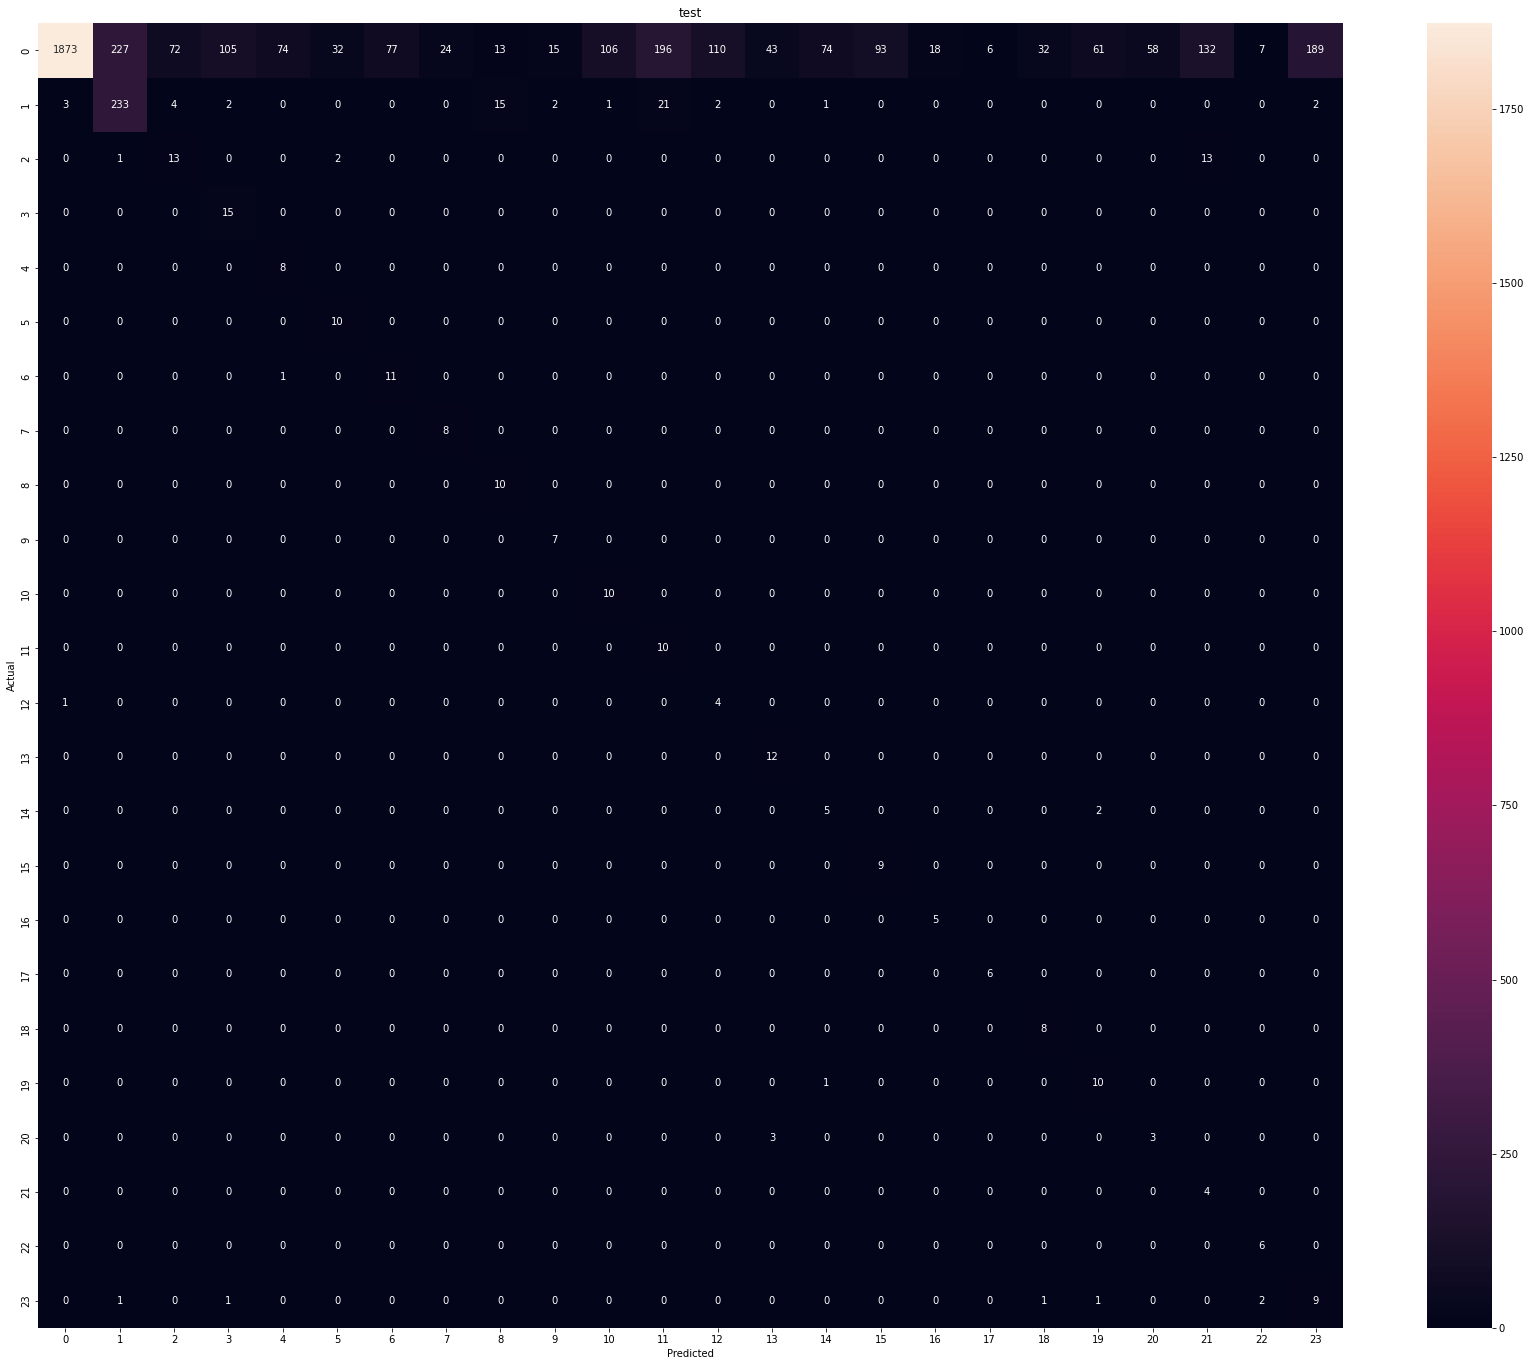

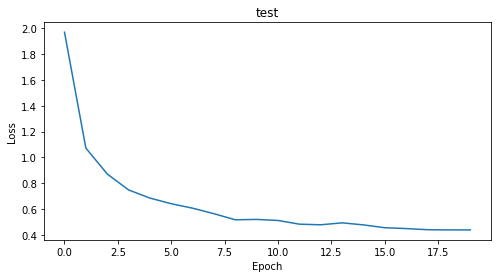

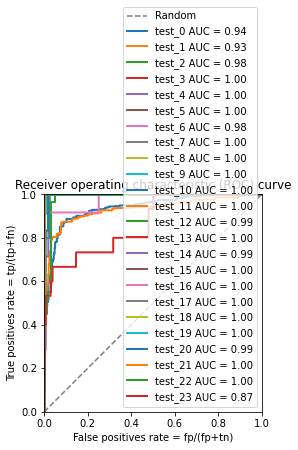

In [96]:
# Tensorflow

# DATA_PATH = Path("../data_generation/training_data/tloop_8_80_T/test_matrices.npz") # For Tensorflow, load the matrices .npz file
# MODEL_DIR = Path("results/ANN/tloop_8_80_T")
# DATA_PATH = Path("../data_generation/training_data/gnravall_8_80_T/test_matrices.npz") # For Tensorflow, load the matrices .npz file
# MODEL_DIR = Path("results/ANN/gnravall_8_80_T")
DATA_PATH = Path("../data_generation/training_data/clusters_8_80_T/test_matrices.npz") # For Tensorflow, load the matrices .npz file
MODEL_DIR = Path("results/ANN/clusters_8_80_T")
# DATA_PATH = Path("../data_generation/training_data/gnra_8_80_T/test_matrices.npz") # For Tensorflow, load the matrices .npz file
# MODEL_DIR = Path("results/ANN/gnra_8_80_T")
TITLE = "test"
NUM_CLASSES = 24

stats_tensorflow(DATA_PATH, MODEL_DIR, NUM_CLASSES, TITLE=TITLE)

clusters_10_80_T
400/400 [==============================] - 1s 1ms/step
{'accuracy': 0.40963855421686746,
 'confusion_matrix': array([[2190,  316,  127,  149,  172,   31,  302,  233,   40,   50,  298,
         386,  260,  105,  305,   56,   11,   15,  151,   58,  101,   66,
           4,  466],
       [   1,  237,    0,    3,    0,    0,    3,    1,    4,    0,    1,
          25,    1,    0,    2,    0,    0,    0,    1,    0,    0,    0,
           0,   11],
       [   0,    0,   23,    0,    0,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
           0,    0],
       [   0,    0,    0,   16,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    9,    0,    0,    0,    0,    0,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,   

/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clusters_24_80_T
471/471 [==============================] - 1s 1ms/step
{'accuracy': 0.5237083277991765,
 'confusion_matrix': array([[3499,  623,  263,   90,   63,   21,  475,  240,  190,   55,   74,
         593,   81,   66,   61,   16,    2,    3,   40,   37,  134,  169,
         136,  110],
       [   5,  261,    1,    0,    0,    0,    5,    0,    0,    0,    2,
           2,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,   26,    0,    0,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    6,
           0,    0],
       [   0,    0,    0,   19,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    7,    0,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    

/local/tmp.2320472/ipykernel_3991070/3133896474.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


32/32 [==============================] - 0s 1ms/step
{'accuracy': 0.9960238568588469,
 'auc': 0.9999675387911446,
 'confusion_matrix': array([[211,   0],
       [  2, 290]]),
 'f1': 0.9965635738831615,
 'fpr': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        

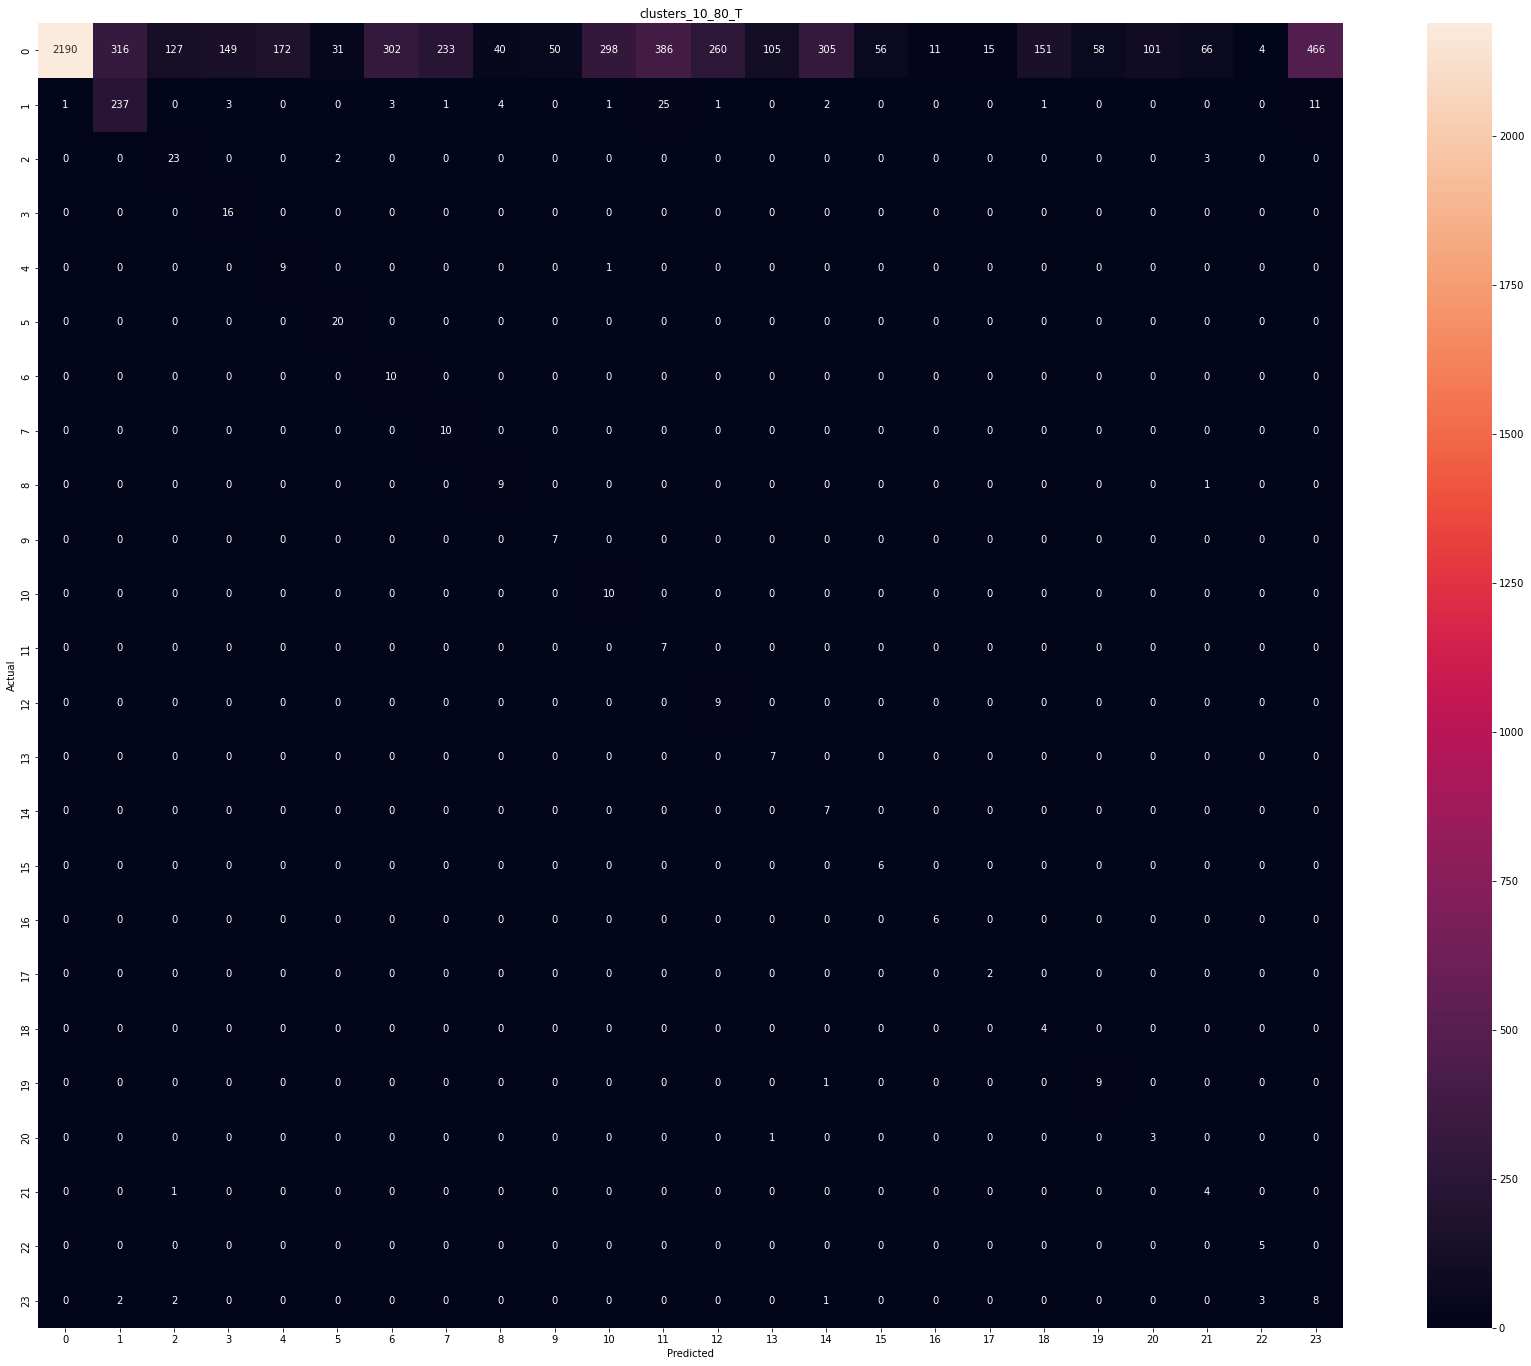

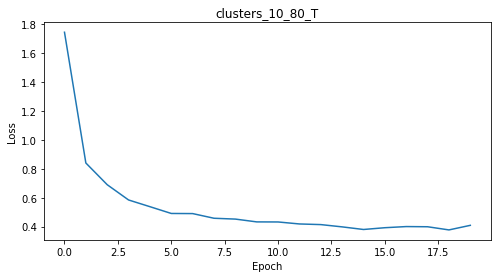

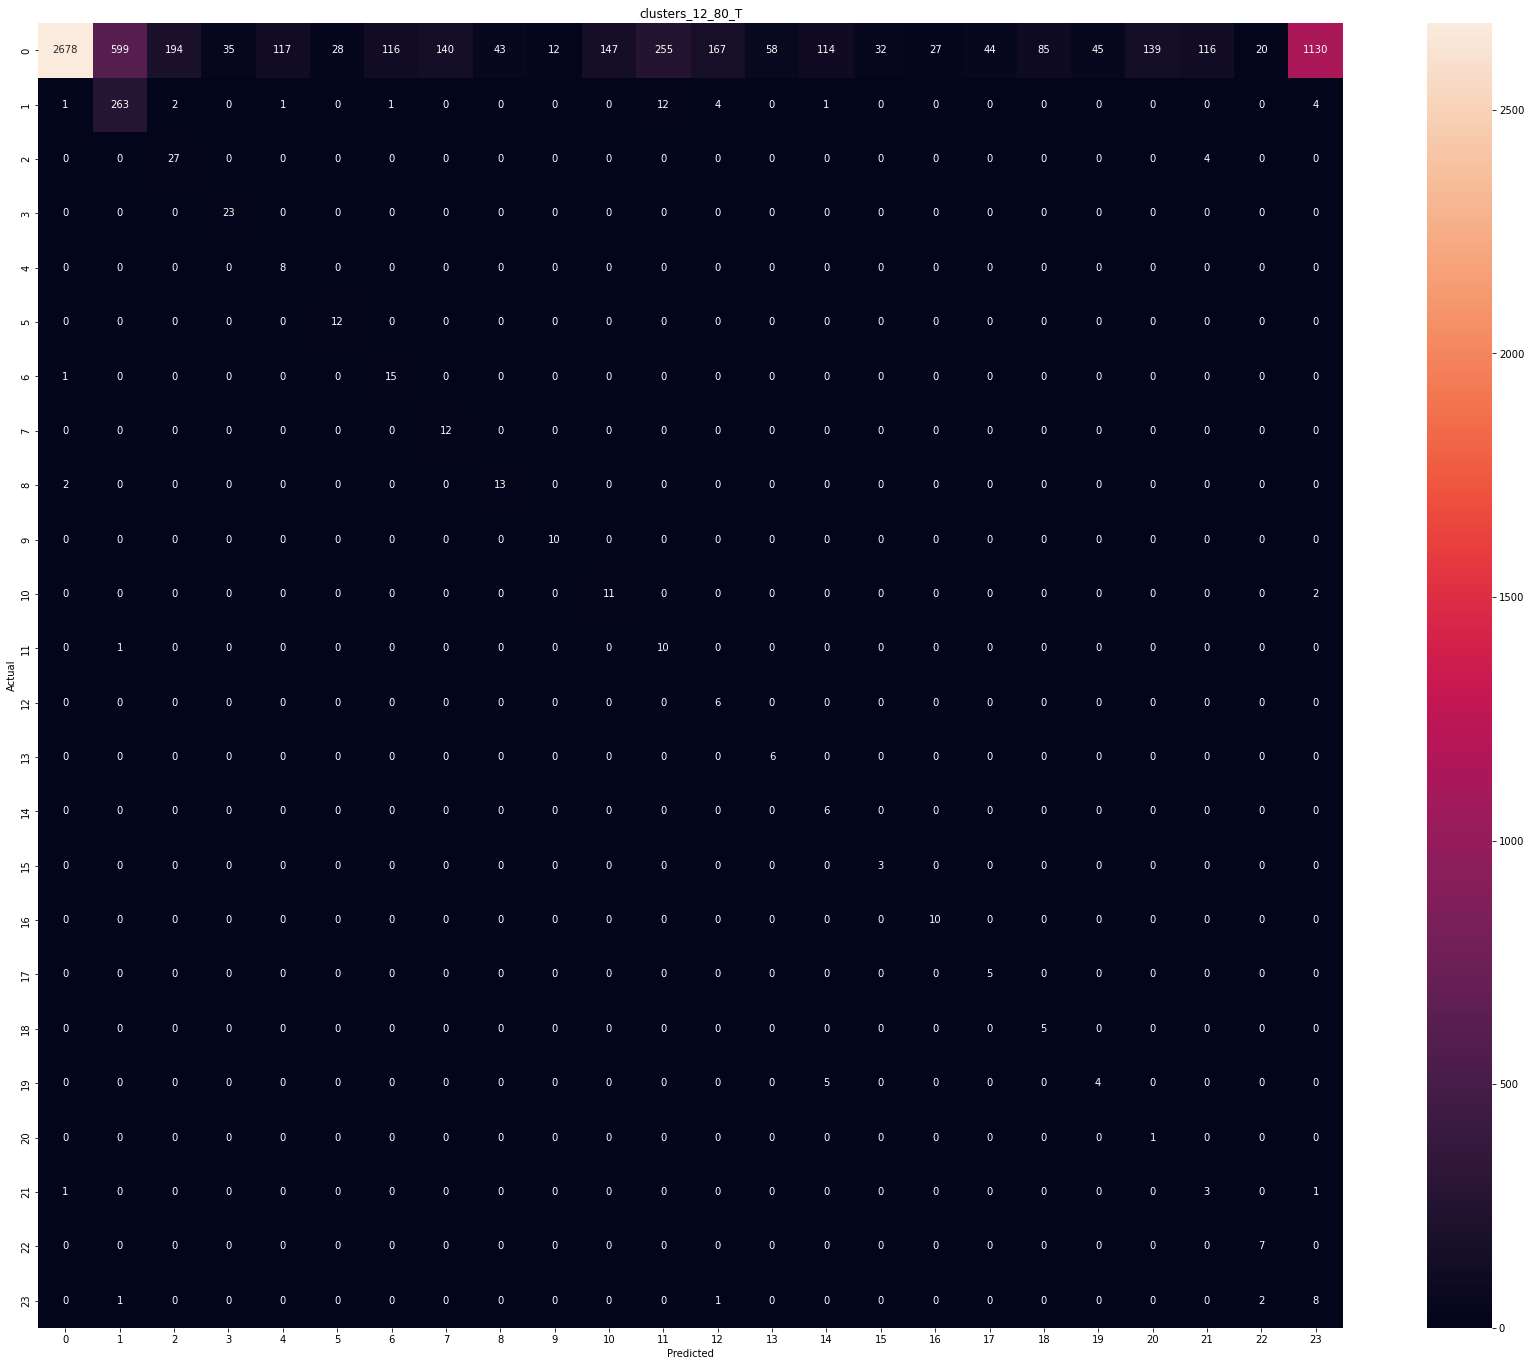

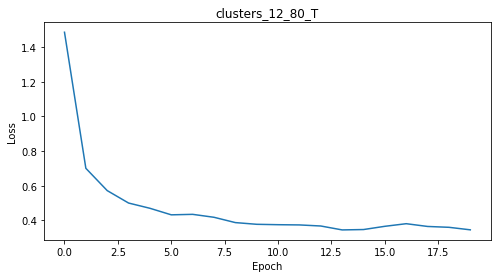

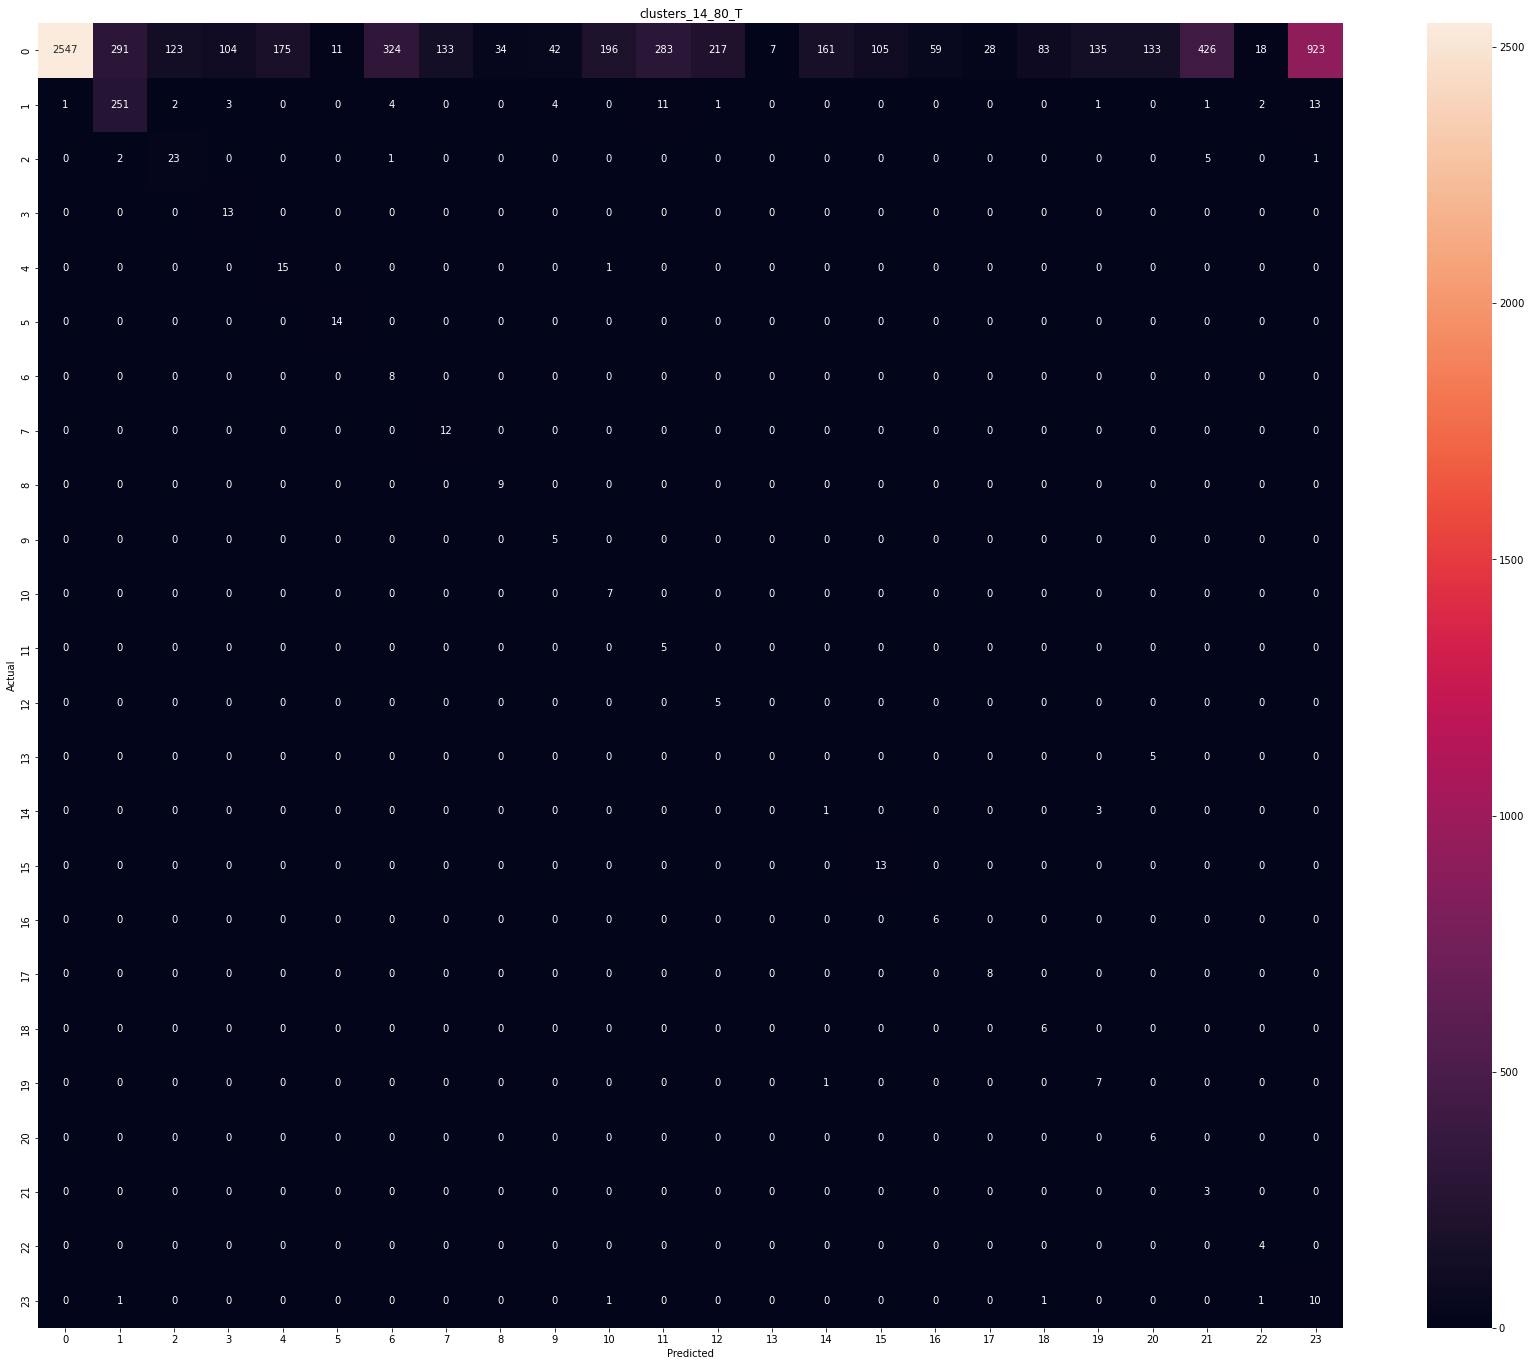

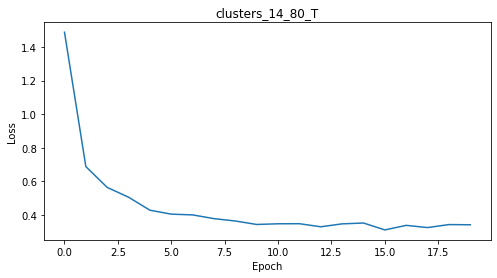

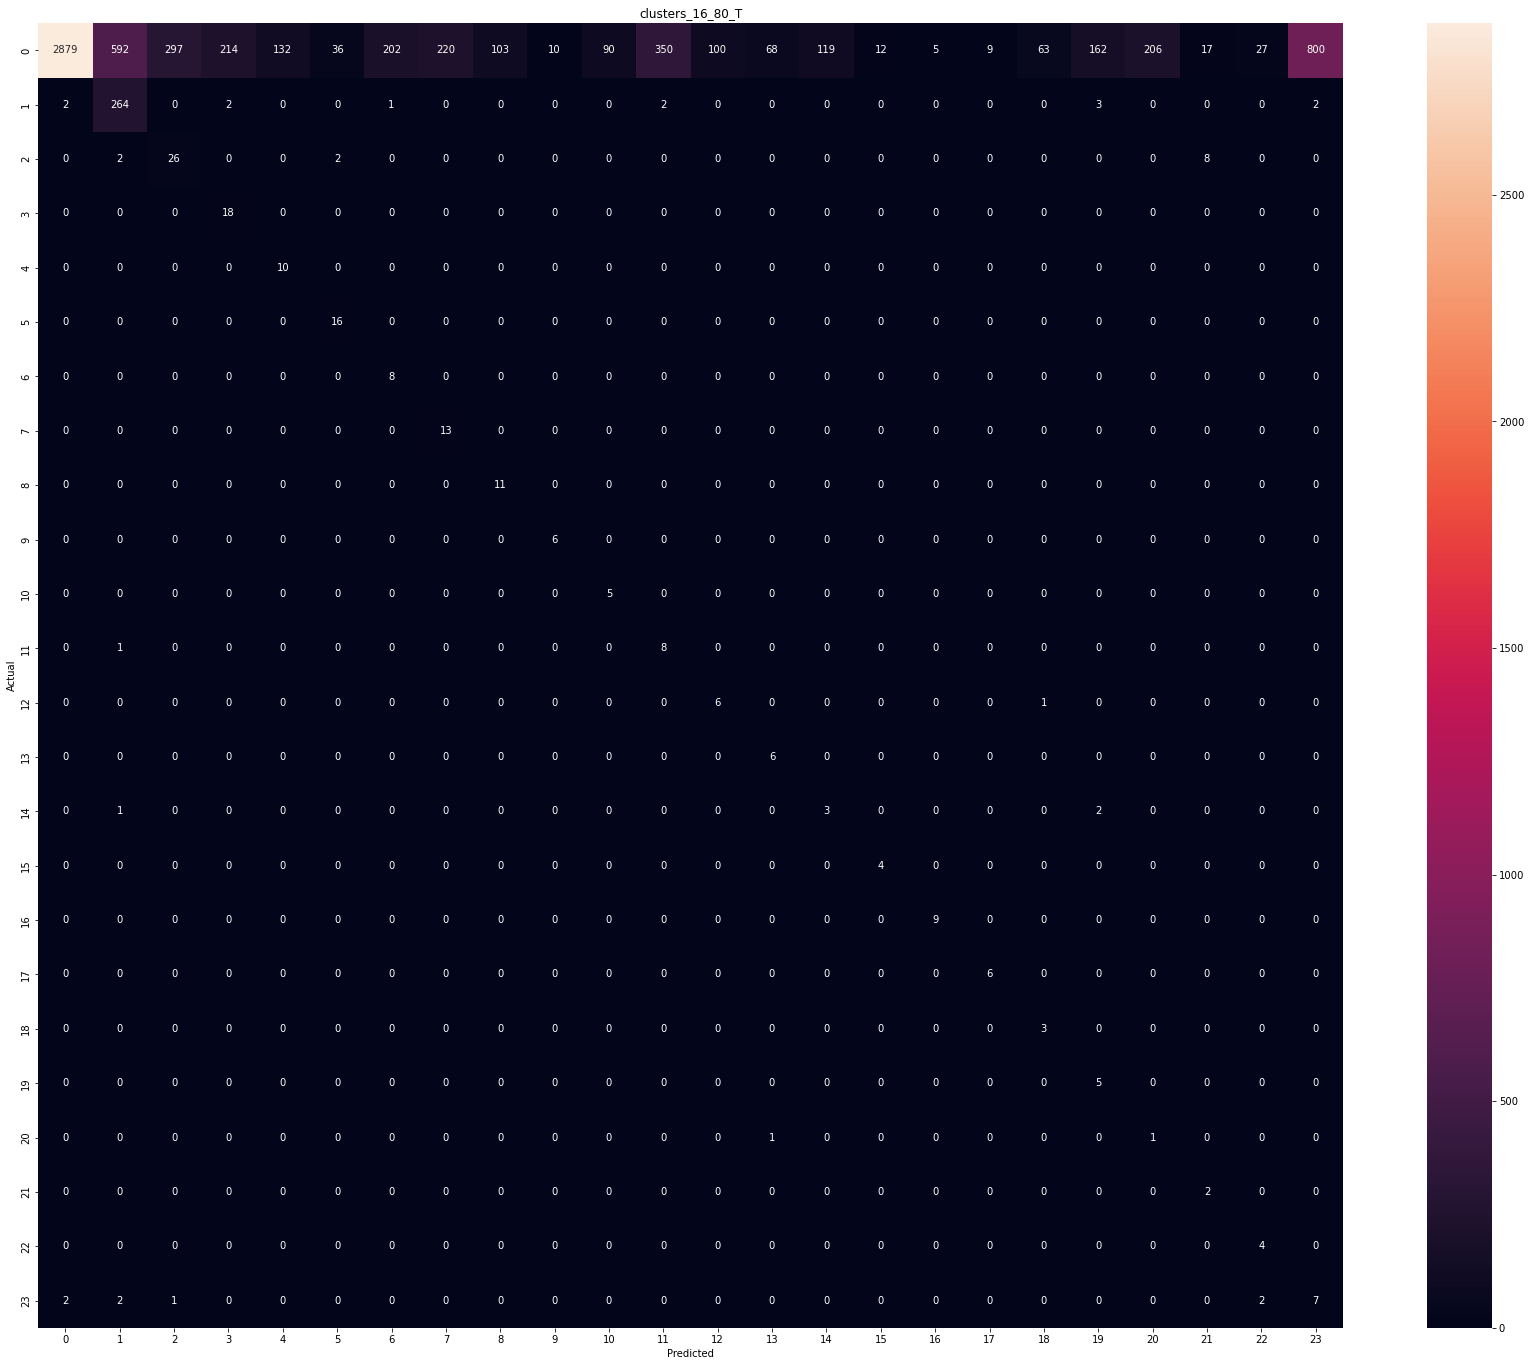

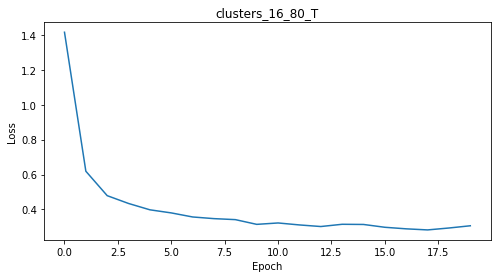

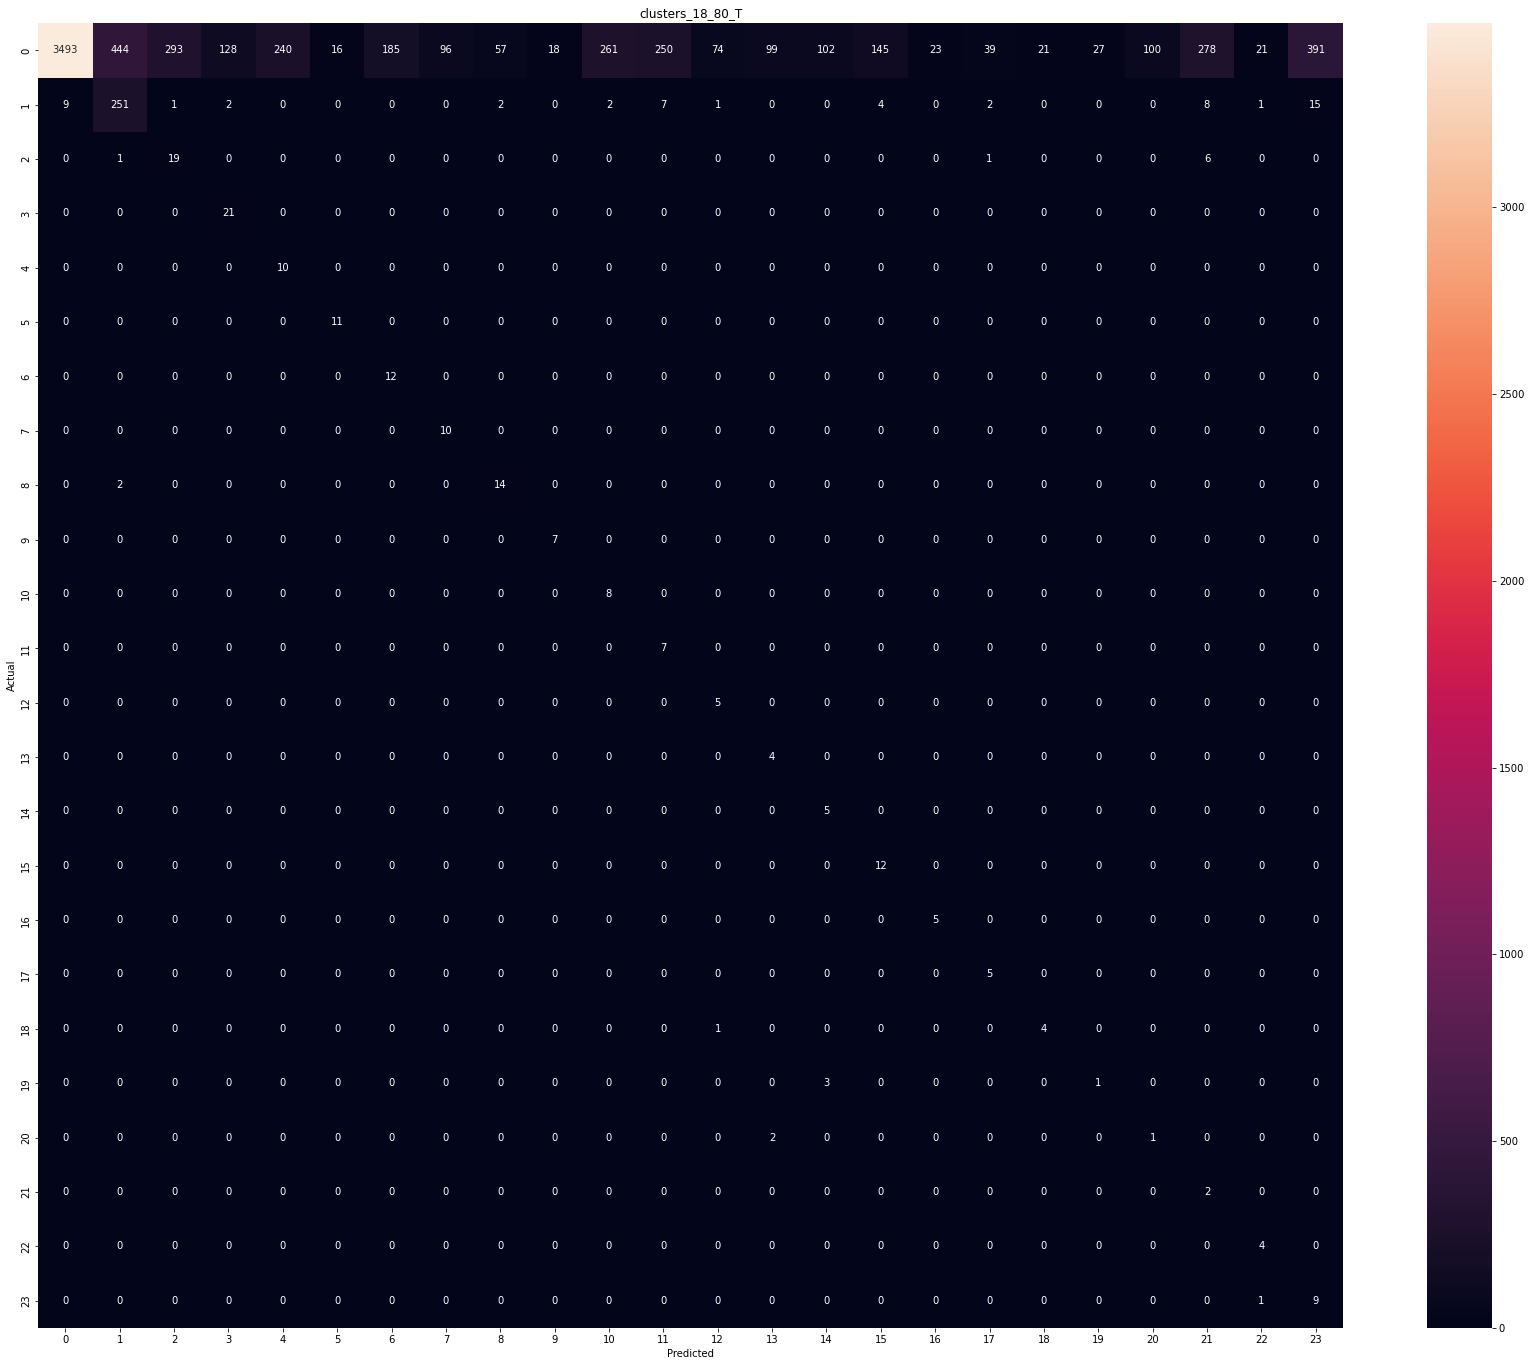

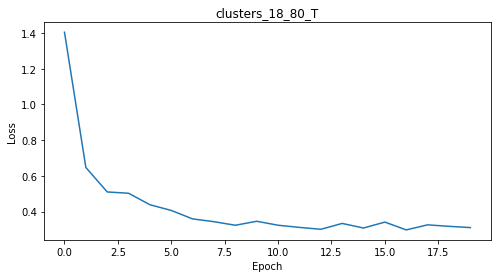

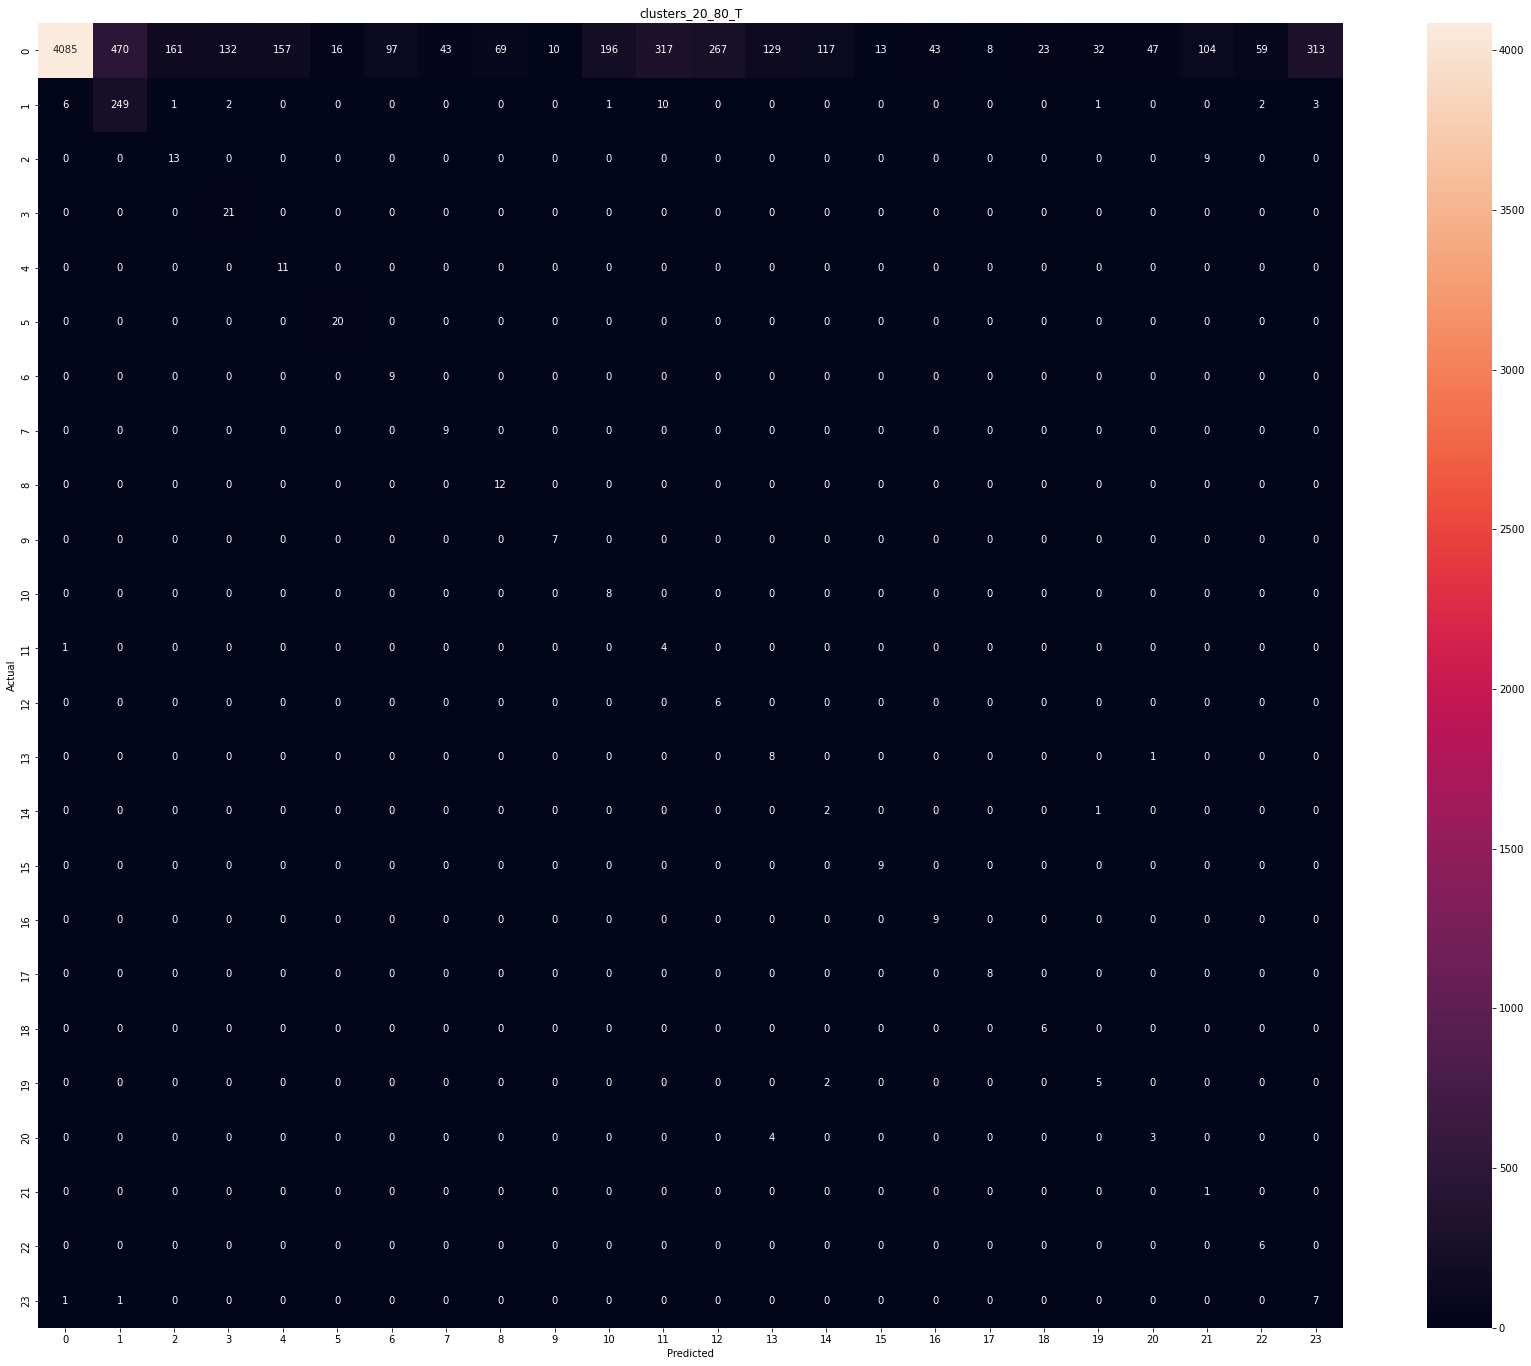

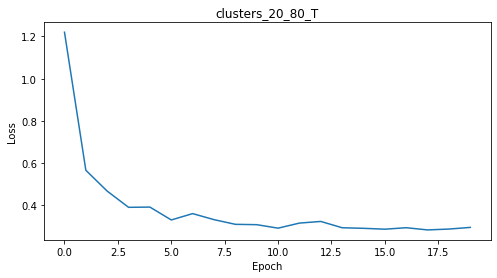

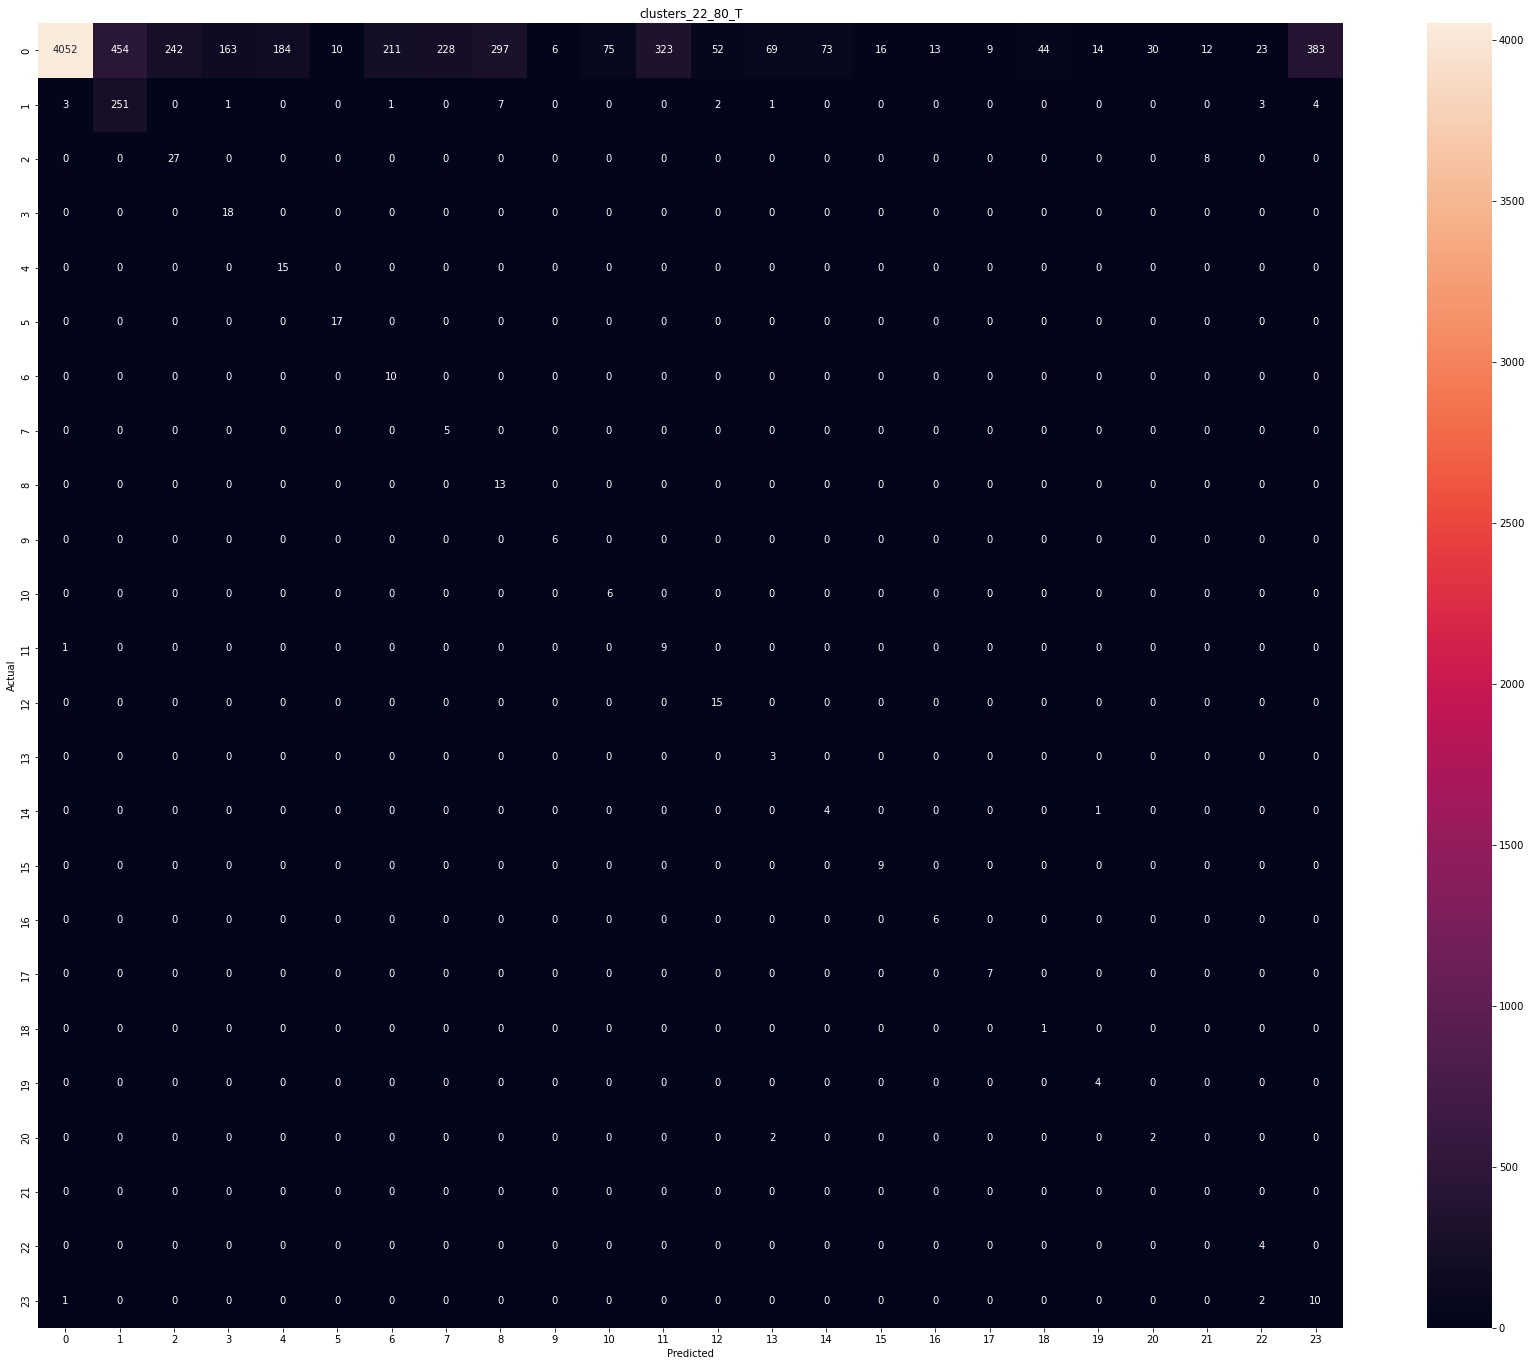

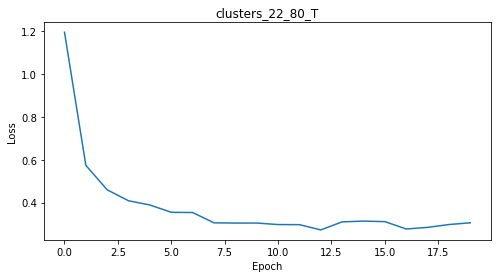

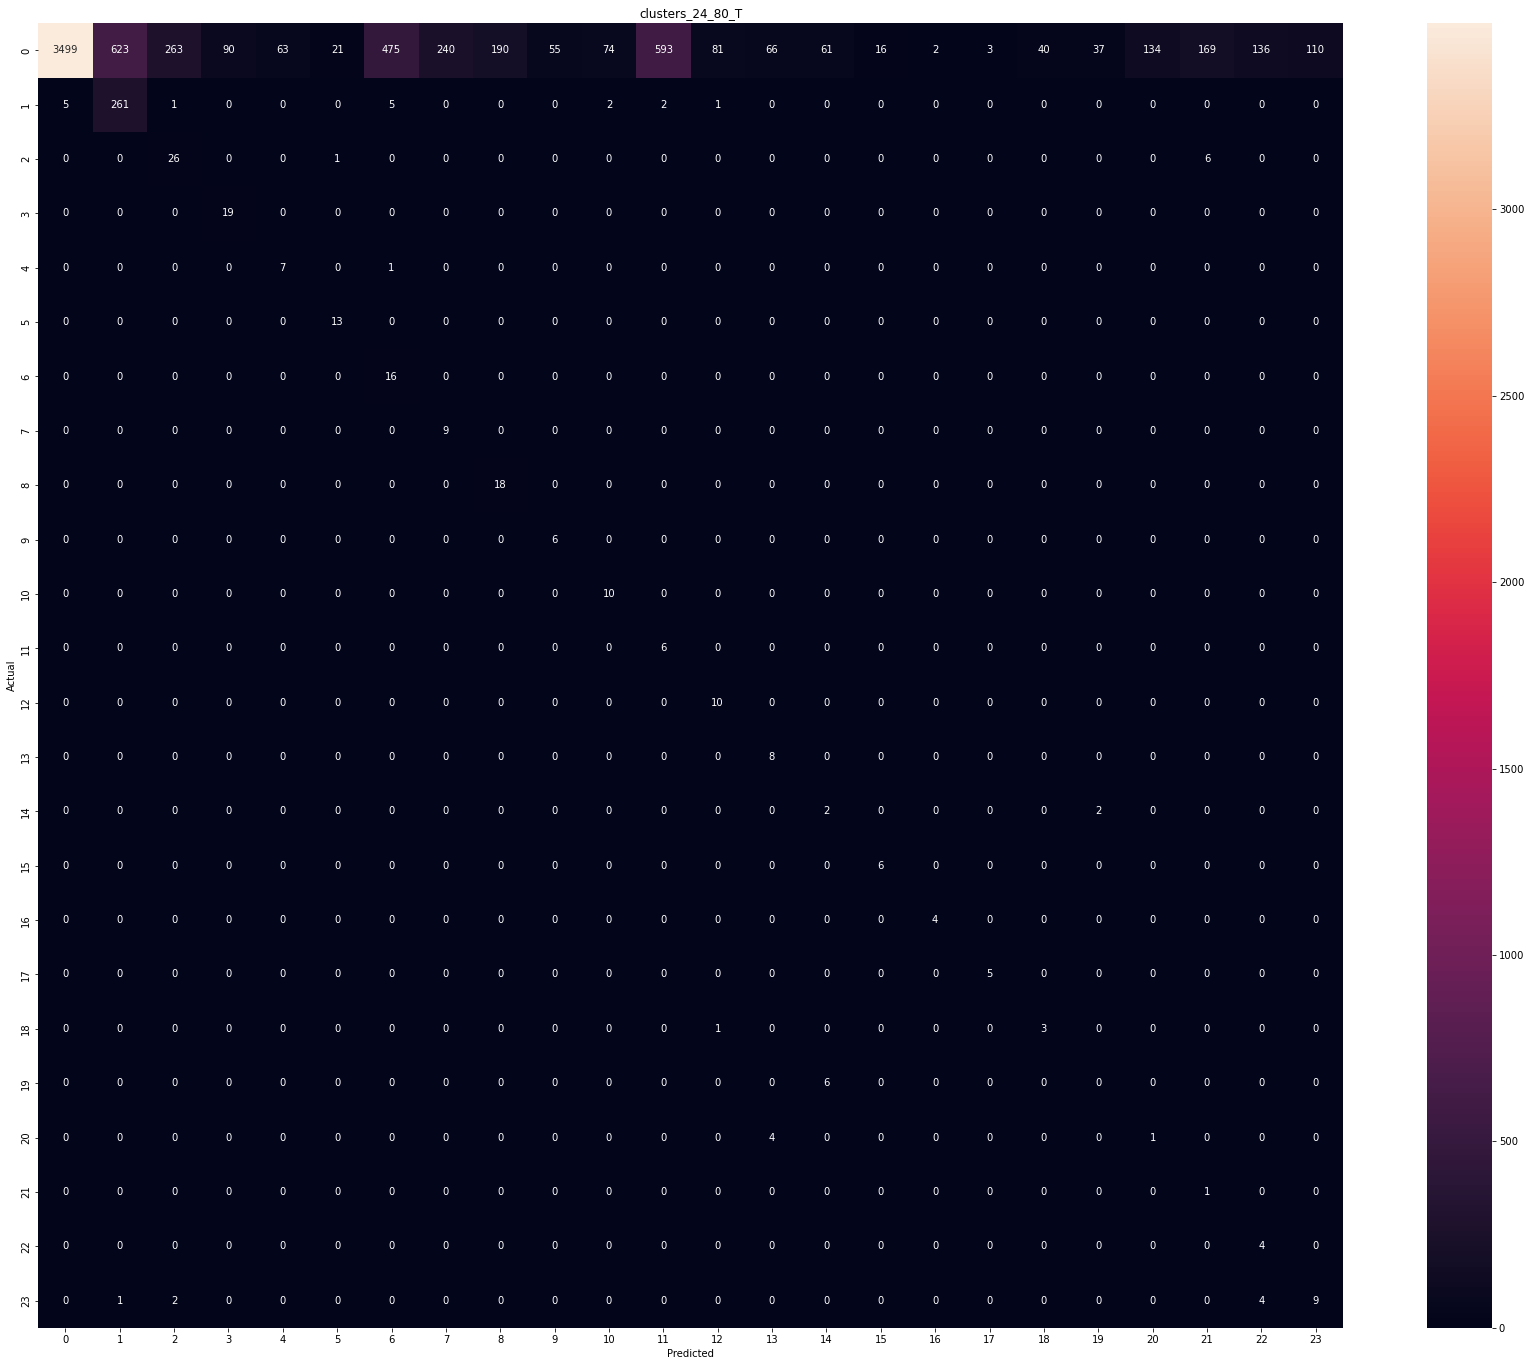

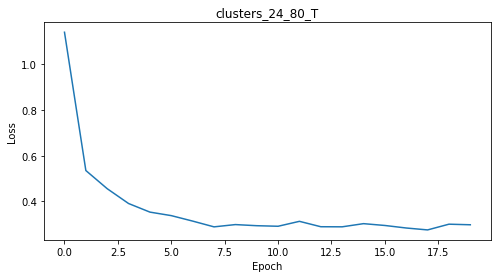

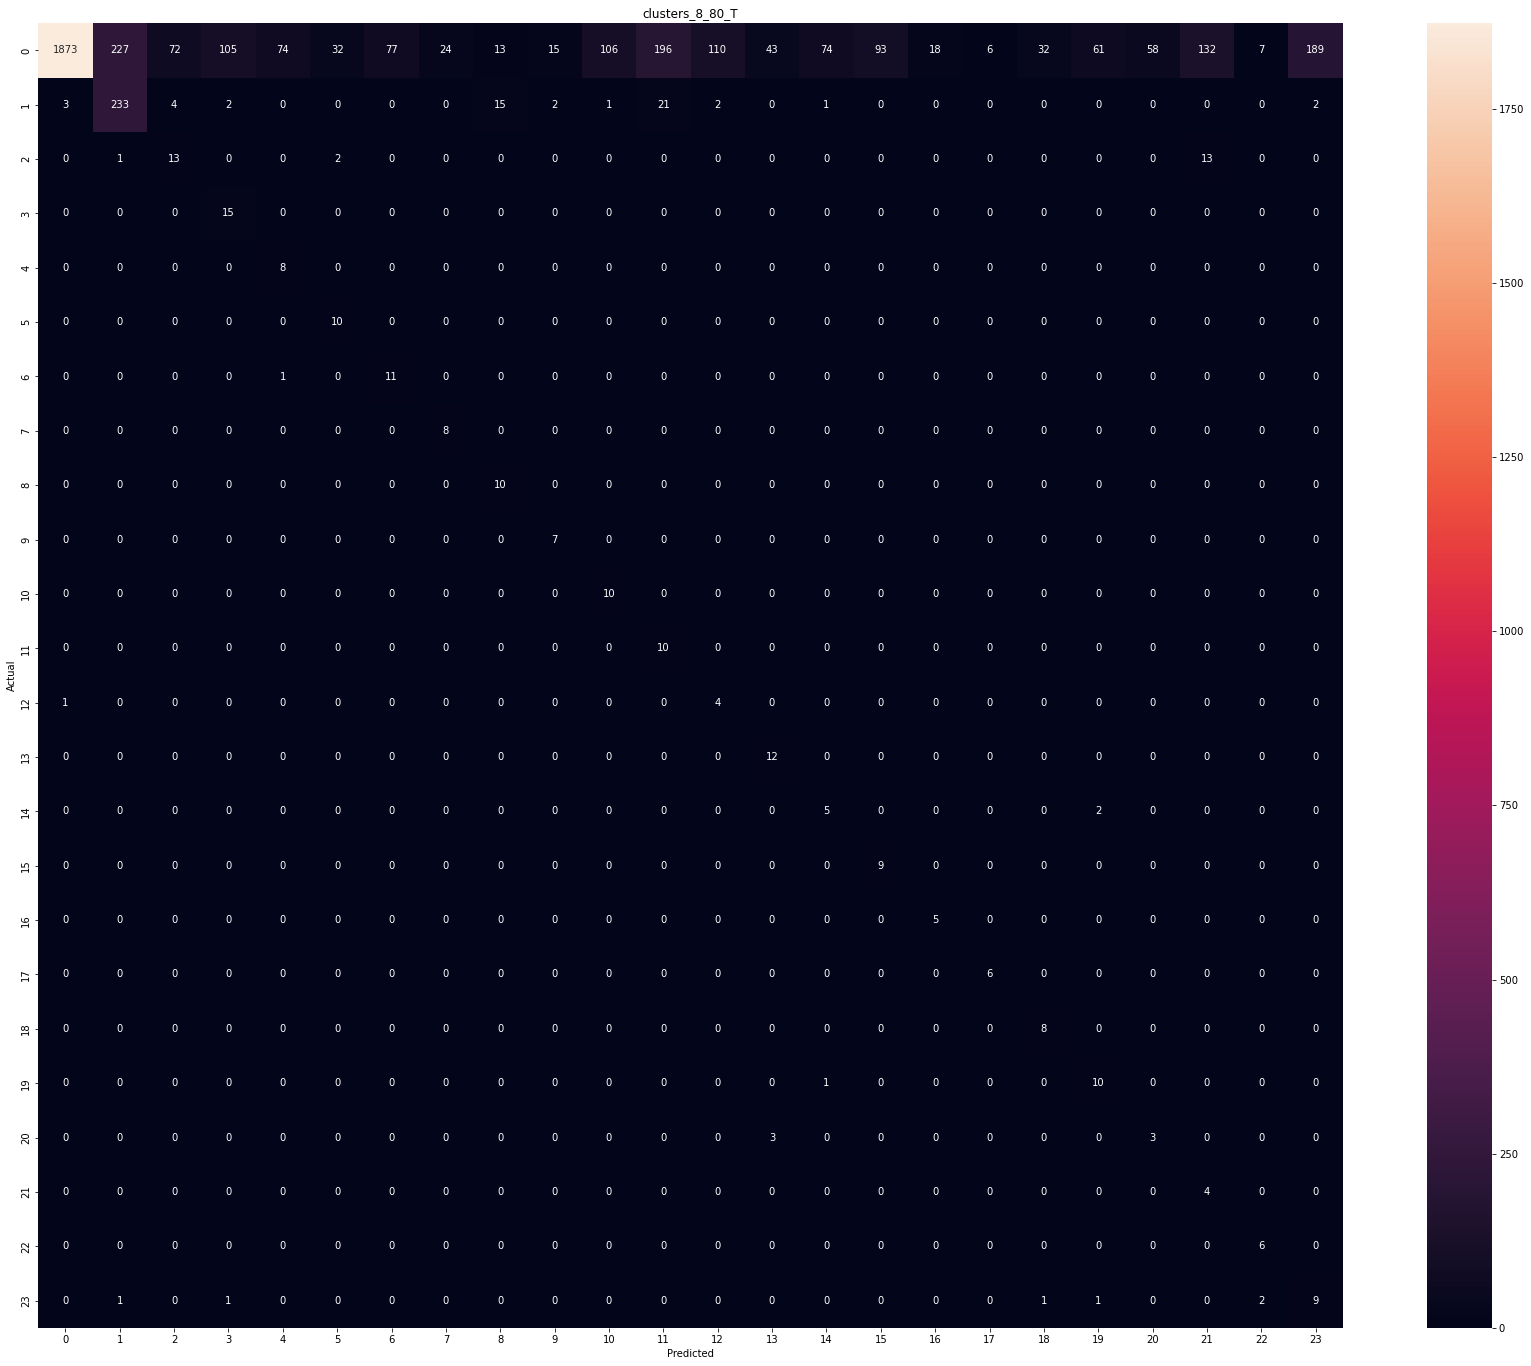

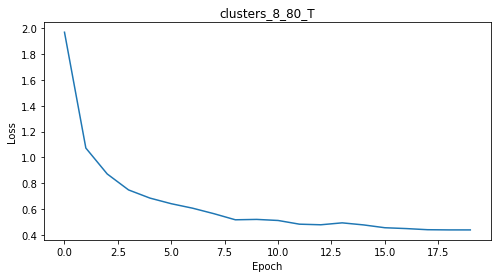

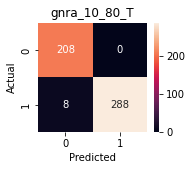

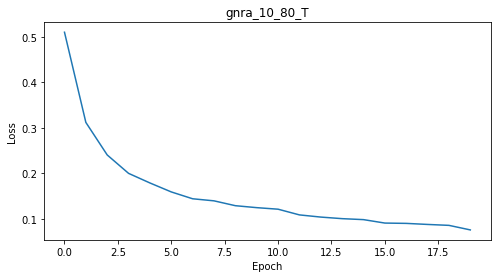

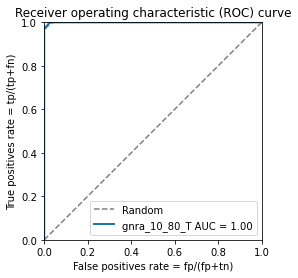

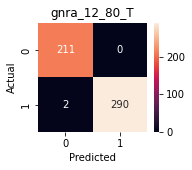

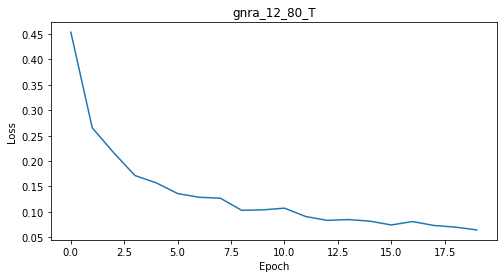

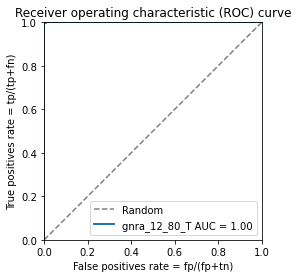

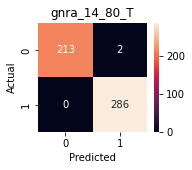

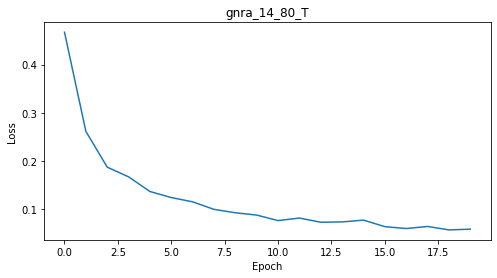

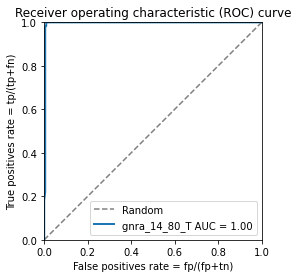

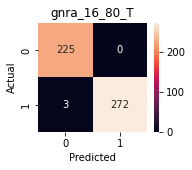

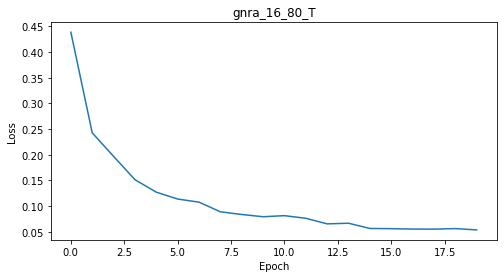

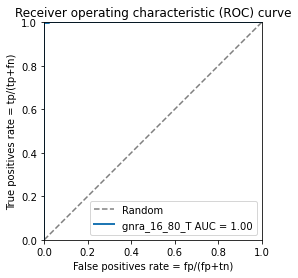

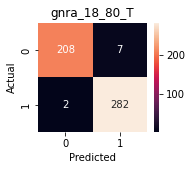

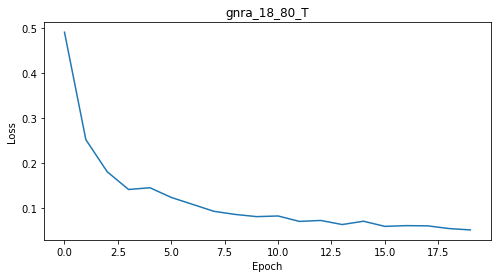

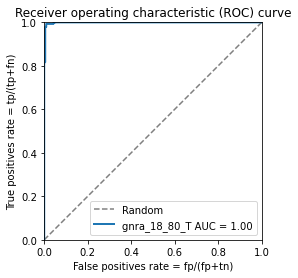

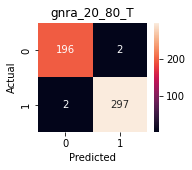

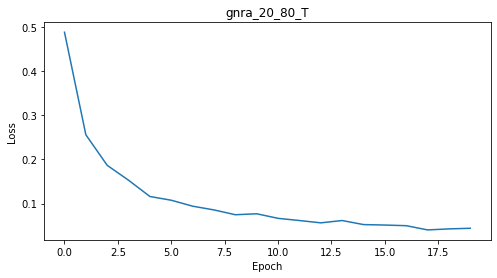

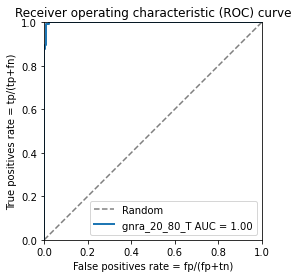

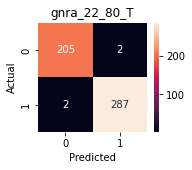

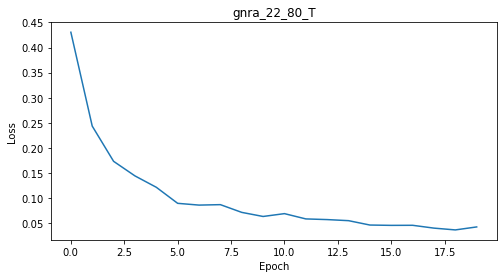

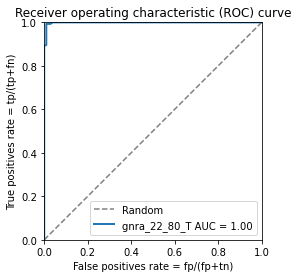

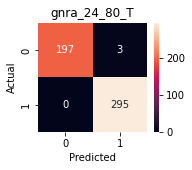

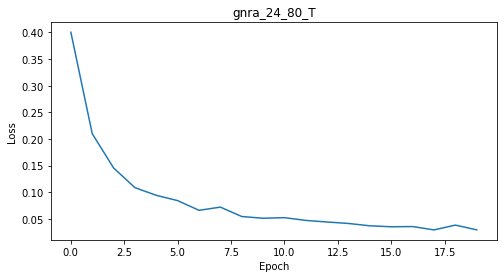

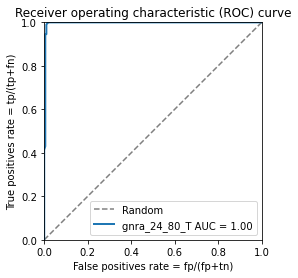

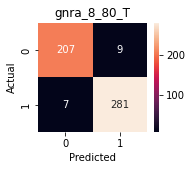

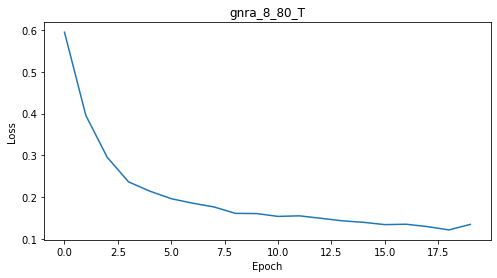

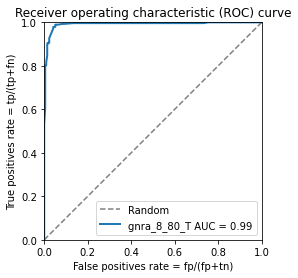

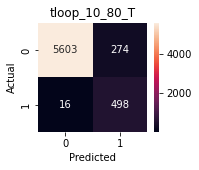

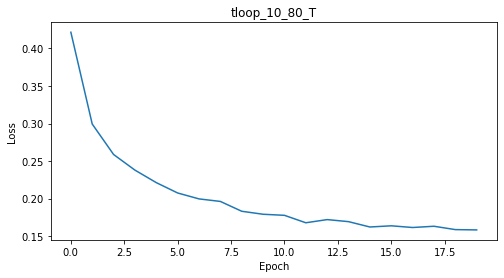

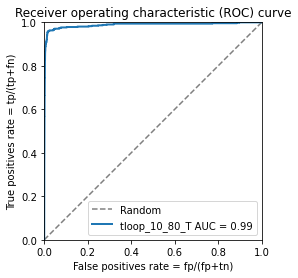

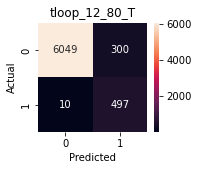

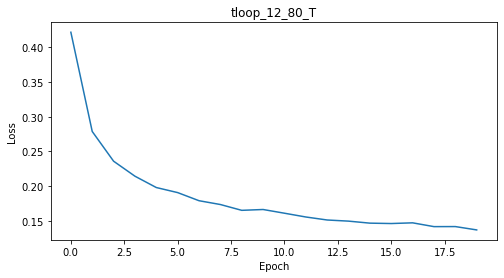

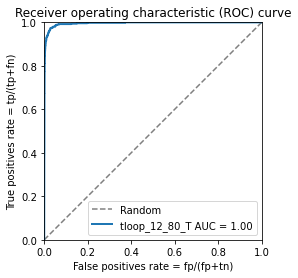

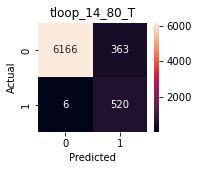

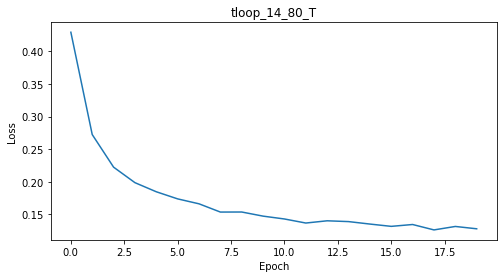

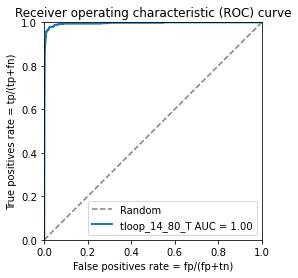

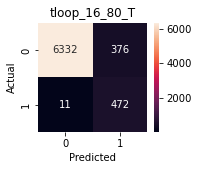

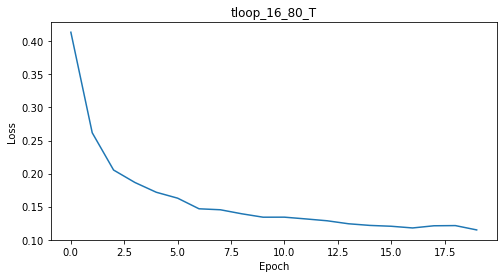

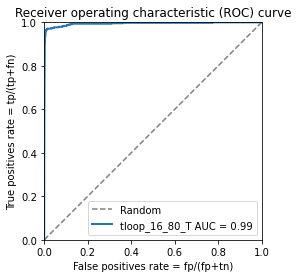

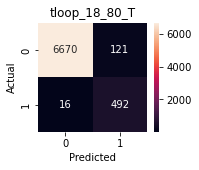

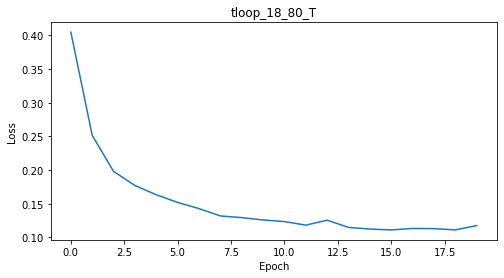

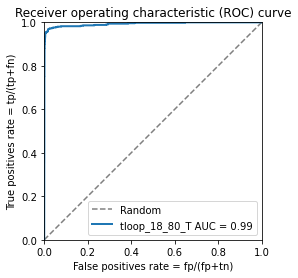

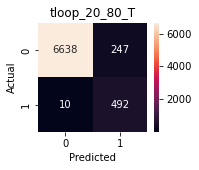

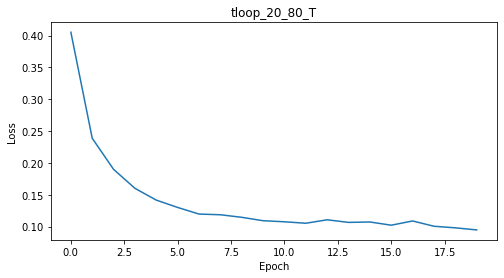

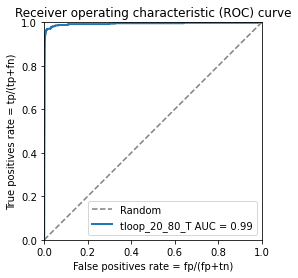

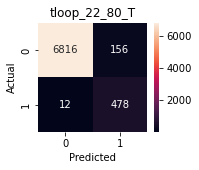

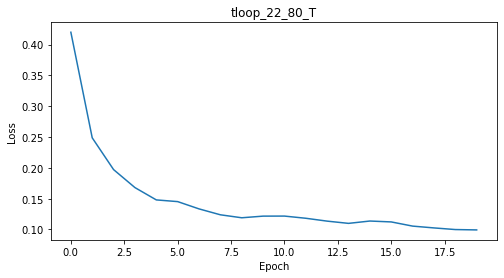

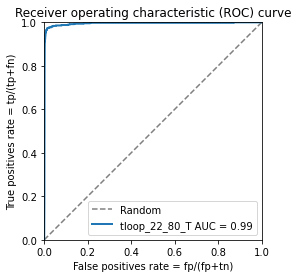

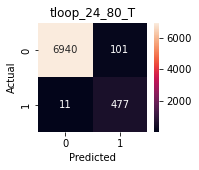

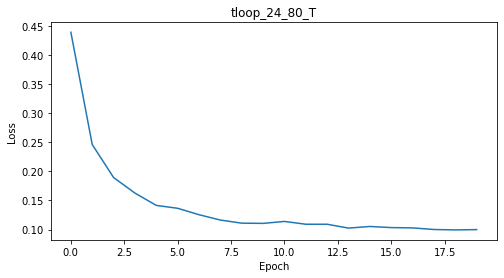

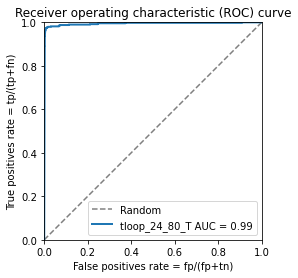

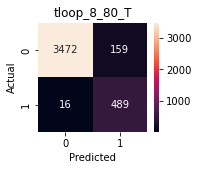

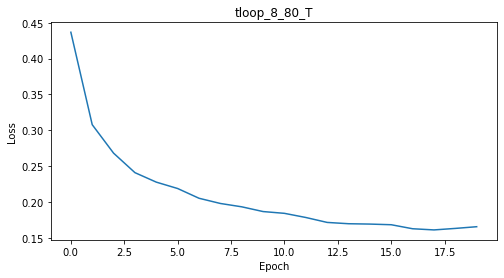

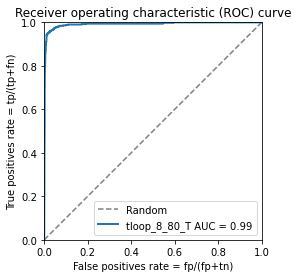

In [110]:
# Tensorflow loop # TODO make pytorch loop also

DATA_DIRS = Path("../data_generation/training_data/")
MODELS_DIR = Path("results/ANN/")

for data_dir in sorted(os.listdir(DATA_DIRS)):
    if os.path.isfile(DATA_DIRS/data_dir): continue
    if data_dir[-1] == "U": continue
    if "gnravall" in data_dir: continue
    
    DATA_PATH = DATA_DIRS/data_dir/"test_matrices.npz"
    MODEL_DIR = MODELS_DIR/data_dir
    TITLE = data_dir

    if "clusters" in data_dir:  NUM_CLASSES = 24
    else:                       NUM_CLASSES = 2

    print(data_dir)
    stats_tensorflow(DATA_PATH, MODEL_DIR, NUM_CLASSES, TITLE=TITLE)

In [74]:
model = get_tf_model(Path("results/ANN/gnrareal_8_80_T"))

single_test = [
    [1,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,1,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,1,0],
    [0,0,0,1,0]]

model.predict(np.array([single_test]))[0]

1/1 [==============================] - 0s 101ms/step


array([0.07246614, 0.92753386], dtype=float32)